## CUQIpy component final project

**Note: under construction to be finalized by midnight 21 July 2024** 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cuqi
from cuqi.model import Model #, LinearModel
from cuqi.geometry import MappedGeometry, Continuous1D, KLExpansion #, Geometry, Continuous
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.sampler import MH, NUTS
from scipy.linalg import lu_factor, lu_solve

from beam_model_1D import BeamModel1D

np.random.seed(10)

In [2]:
class hydraulic_class():
    def __init__(self, N, L=1, source_idx=0):
        self.L = L
        self.N = N
        self.x = np.linspace(self.L/self.N,1,self.N)
        self.dx = self.L/self.N
        self.source_idx = source_idx
        self.source()

    def forward(self, a):
        diag1 = -(a[1:] + a[:-1])
        diag1 = np.concatenate([diag1,[-a[-1]]])
        diag2 = a[1:]

        Dxx = np.diag(diag1) + np.diag(diag2,-1) + np.diag(diag2,1)
        Dxx /= self.dx*self.dx

        lu, piv = lu_factor(Dxx)

        sol = lu_solve((lu, piv), self.b_terms) 

        return np.array(sol)

    def source(self, n_source=5, std=0.02):
        dist = self.L/(n_source+1)
        source_coords = np.linspace( dist,self.L-dist, n_source )
        self.b_terms =  np.exp( -0.5*(self.x - source_coords[self.source_idx])**2/std/std )/std/np.sqrt(2*np.pi) 


- Create a mapped KL expansion domain geometry with the mapping `lambda x: exp(x)`.
- Create a continuous range geometry for the range.
- Create a user define CUQIpy model representing the forward model (hydraulic).
- Create a Gaussian i.i.d. prior
- Create a Gaussian likelihood (for one injection pattern)
- Create a synthetic data from the given true porosity.
- Create a posterior
- Use MH for sampling
- Use NUTS for sampling
- Compare the results (ess, pair_plot, trace_plot, plot_ci)
- Comment on the computational cost of nuts (tree size, FD)
- Create a posterior with multiple likelihoods (for multiple injection patterns)
- Use MH for sampling
- Comment on how adding more data helped the inference.



In [3]:
# Data and initialization
from os import name


U = lambda x: np.exp(x)             # Define mapping
L = 100                               # domain length 1
N_hydro = 128                       # Number of measurement points for hydrolic problem
N_points = 100                       # Number of discretization points
N_KL = 10                            # Number of terms in KL expansion
grid1 = np.linspace(0,L,N_points)   # Discretization for domain

hydraulic = hydraulic_class(N=N_points,  L=L)
beam      = BeamModel1D(nelx=N_points-1, L=L)

# Create Beam and hydrolic models
model_hydraulic = Model(forward=hydraulic.forward, 
                range_geometry=Continuous1D(grid=grid1),
                domain_geometry=MappedGeometry(KLExpansion( grid=grid1,num_modes=N_KL ), map = U))

model_Beam = Model(forward=beam.forward, 
                range_geometry=Continuous1D(grid=grid1),
                domain_geometry=MappedGeometry(KLExpansion( grid=grid1,num_modes=N_KL ), map = U))

# # Test both mdoels for som input
# print(model_hydraulic(np.ones(5)))
# print(model_Beam(np.ones(5)))

# # Gaussian prior: thk -> test it on beam domain (on Zs in KL expansion)
prior = Gaussian(0,1,geometry=model_Beam.domain_geometry, name='thk');
# thk.sample(5).plot();

# Gaussian Likelihood: v
data_test = np.ones(5)
sigma_noise = 5.
likelihood = cuqi.distribution.Gaussian(mean=model_Beam, cov=sigma_noise**2, name='v')#.to_likelihood(data_test)
# print(v(data_test))
#likelihood.enable_FD()
# likelihood(thk=Zs_true).sample(1).plot()
print(model_Beam.range_geometry)

print(model_Beam.domain_geometry)

Continuous1D(100,)
MappedGeometry(KLExpansion(10,))


In [4]:
# # Gaussian Likelihood
# data_test = np.ones(5)
# likelihood = cuqi.distribution.Gaussian(mean=model_Beam, cov=0.05**2).to_likelihood(data_test)
# print(likelihood)

/home/andfr/miniconda3/envs/clean_cookie/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


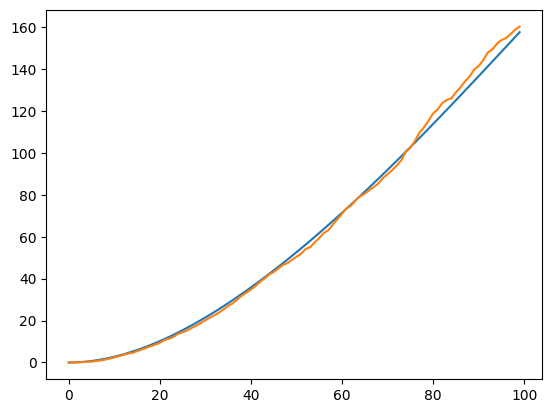

ValueError: The keyword "thkVec" is not a mutable, conditioning variable or parameter name of this distribution.

<Figure size 640x480 with 0 Axes>

In [5]:
# Create sunthetic data 
Zs_true = prior.sample(1)
# Xs_true = Zs_true.funvals               # True parameters Xs for beam model
# t_true = U(Xs_true)                     # True beam thickness
t_true = Zs_true.funvals                # True beam thickness
v_true = beam.forward(t_true)           # True beam deflection

def create_matrix(n):
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i, j] = (1 - abs(i - j) / n)**2
    return matrix

cov = create_matrix(N_points)

epsilon = np.random.multivariate_normal(np.zeros(N_points),cov)
# epsilon = np.random.standard_normal(N_points)   # sample a noise vector of size N_points
epsilon /= np.linalg.norm(epsilon)              # normalize with Euclidean norm
sigma_obs = 0.5*np.sqrt(np.sum(v_true**2*beam.L/N_points))/np.sqrt(N_points) # define 5% noise standard deviation with respect to the L2 norm of the pressure

# Noisy data #TODO: INVERSE CRIME
v_obs = v_true + np.linspace(0,1,N_points)*epsilon*sigma_obs # add noise to p and append

plt.plot(v_true)
plt.plot(v_obs)
plt.show()
plt.figure()
likelihood(thk=Zs_true).sample(1).plot()

In [ ]:
# posterior model
joint = JointDistribution(likelihood,prior)
posterior = joint(v=v_obs)
print(posterior)
posterior.geometry

Posterior(
    Equation:
	 p(thkVec|v) ∝ L(thkVec|v)p(thkVec)
    Densities:
	v ~ CUQI Gaussian Likelihood function. Parameters ['thkVec'].
 	thkVec ~ CUQI Gaussian.
 )


MappedGeometry(KLExpansion(10,))

In [ ]:
# MH Sampler
Ns = 5000
thk_ini_guess = np.ones(5)
sampler_MH = MH(posterior,scale=1.1)
samples_MH = sampler_MH.sample(Ns)

Sample 5000 / 5000

Average acceptance rate: 0.103 



/tmp/ipykernel_47208/1144592777.py:5: RuntimeWarning: overflow encountered in exp
  U = lambda x: np.exp(x)             # Define mapping


Sample 110 / 110


 None,

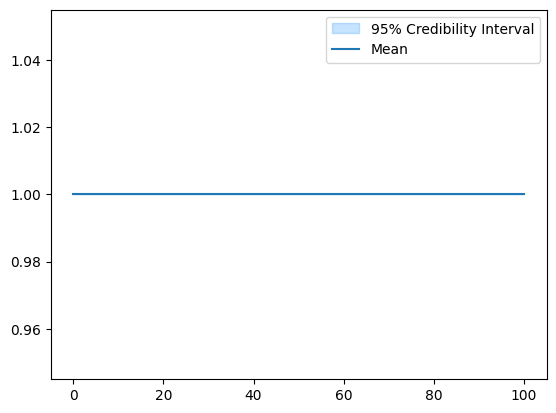

In [ ]:
# NUTS Sampler
Ns = 100
thk_ini_guess = np.zeros(N_KL)
# help(NUTS)
posterior.enable_FD()
sampler_NUTS = NUTS(posterior, x0=thk_ini_guess)
samples_NUTS = sampler_NUTS.sample(Ns,Nb=10)
sampler_NUTS.num_tree_node_list
samples_NUTS.plot_ci()

In [ ]:
print(samples_MH.compute_ci())
print(samples_NUTS.compute_ci())

[[35.8118052  10.28421306  4.3203356   1.30501063  0.4572439  -0.67735557
  -0.69389577 -0.94553906 -1.20623075 -2.04902531]
 [38.49995965 14.66289278  8.81646546  6.28561558  4.97140044  4.19139366
   3.56087347  3.1614526   3.57095906  2.67684684]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
print(samples_MH.compute_ess())
print(samples_NUTS.compute_ess())

[138.99864305 134.5972923  101.58070328 110.18195889 104.76170582
  59.54194902 105.29001203  73.29642663  87.85760664  95.05239314]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


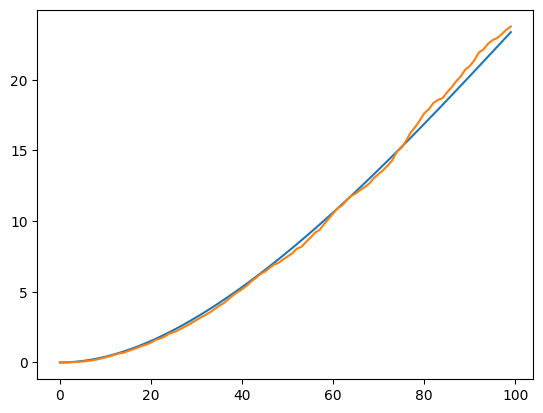

In [ ]:
plt.plot(v_true)
plt.plot(v_obs)

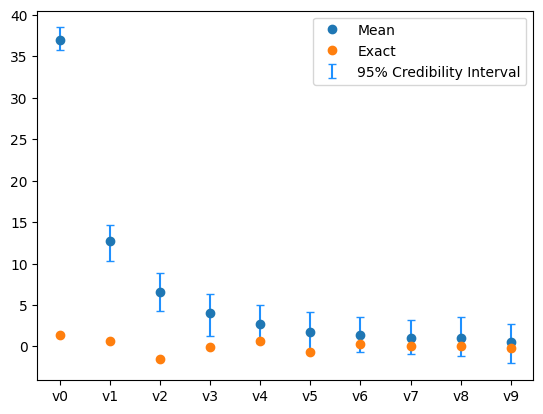

 None,

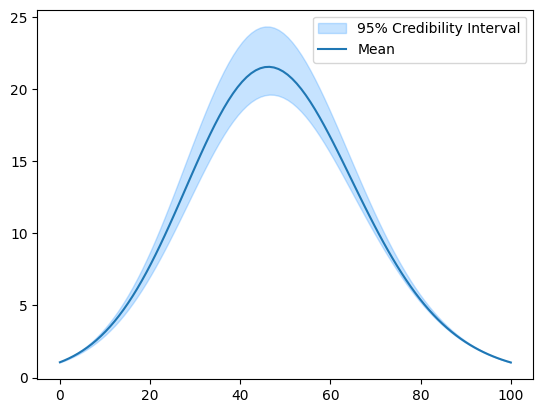

In [ ]:
samples_MH.plot_ci(plot_par=True, exact=Zs_true)
#samples_NUTS.plot_ci(plot_par=True,exact=Zs_true)
plt.show()

plt.figure()
samples_MH.plot_ci(plot_par=False)
#samples_NUTS.plot_ci(plot_par=False,exact=Zs_true)

/home/andfr/miniconda3/envs/clean_cookie/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'v3'}>, <Axes: title={'center': 'v3'}>]],
      dtype=object)

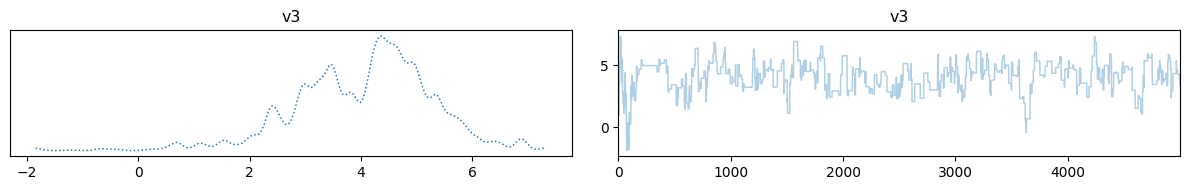

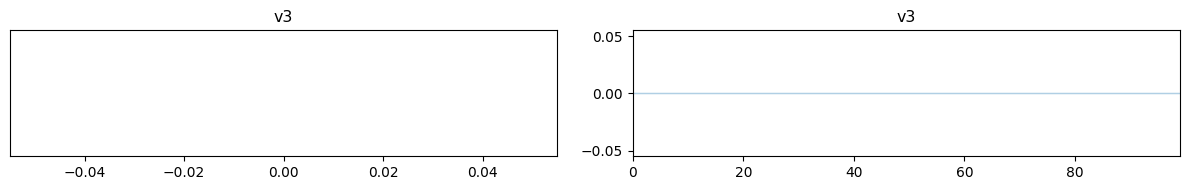

In [ ]:
samples_MH.plot_trace([3])
samples_NUTS.plot_trace([3])
# help(samples_MH.plot_trace)